## 14.4 测试模型

## 导入需要的模块

In [1]:
import colorsys
import os
import time

import numpy as np
from PIL import ImageDraw, ImageFont
from tensorflow.keras.applications.imagenet_utils import preprocess_input

import nets.frcnn as frcnn
from utils.anchors import get_anchors
from utils.utils import cvtColor, get_classes, get_new_img_size, resize_image
from utils.utils_bbox import BBoxUtility

## 定义frcnn类
**<font size=3 color=blue> 【注意】</font>**  
<font size=3 color=blue> 1、把训练完成后在logs目录下的最后一次保存的h5文件，复制到以下代码中，model_path指定的路径！</font>  
<font size=3 color=blue> 2、我这里的路径为："model_path" : '../data/char-14/logs/ep004-loss1.065-val_loss1.018.h5'</font>

In [2]:
#--------------------------------------------#
#   使用自己训练好的模型预测需要修改2个参数
#   model_path和classes_path都需要修改！
#   如果出现shape不匹配
#   一定要注意训练时的NUM_CLASSES、
#   model_path和classes_path参数的修改
#--------------------------------------------#
class FRCNN(object):
    _defaults = {
        #--------------------------------------------------------------------------#
        #   使用自己训练好的模型进行预测一定要修改model_path和classes_path！
        #   model_path指向logs文件夹下的权值文件，classes_path指向model_data下的txt
        #
        #   训练好后logs文件夹下存在多个权值文件，选择验证集损失较低的即可。
        #   验证集损失较低不代表mAP较高，仅代表该权值在验证集上泛化性能较好。
        #   如果出现shape不匹配，同时要注意训练时的model_path和classes_path参数的修改
        #--------------------------------------------------------------------------#
        "model_path"    : '../data/char-14/logs/ep004-loss1.065-val_loss1.018.h5',
        "classes_path"  : 'model_data/voc_classes.txt',
        #---------------------------------------------------------------------#
        #   网络的主干特征提取网络，resnet50或者vgg
        #---------------------------------------------------------------------#
        "backbone"      : "resnet50",
        #---------------------------------------------------------------------#
        #   只有得分大于置信度的预测框会被保留下来
        #---------------------------------------------------------------------#
        "confidence"    : 0.5,
        #---------------------------------------------------------------------#
        #   非极大抑制所用到的nms_iou大小
        #---------------------------------------------------------------------#
        "nms_iou"       : 0.3,
        #---------------------------------------------------------------------#
        #   用于指定先验框的大小
        #---------------------------------------------------------------------#
        'anchors_size'  : [128, 256, 512],
    }

    @classmethod
    def get_defaults(cls, n):
        if n in cls._defaults:
            return cls._defaults[n]
        else:
            return "Unrecognized attribute name '" + n + "'"

    #---------------------------------------------------#
    #   初始化faster RCNN
    #---------------------------------------------------#
    def __init__(self, **kwargs):
        self.__dict__.update(self._defaults)
        for name, value in kwargs.items():
            setattr(self, name, value)
        #---------------------------------------------------#
        #   获得种类和先验框的数量
        #---------------------------------------------------#
        self.class_names, self.num_classes  = get_classes(self.classes_path)
        self.num_classes                    = self.num_classes + 1
        #---------------------------------------------------#
        #   创建一个工具箱，用于进行解码
        #   最大使用min_k个建议框，默认为150
        #---------------------------------------------------#
        self.bbox_util = BBoxUtility(self.num_classes, nms_iou = self.nms_iou, min_k = 150)

        #---------------------------------------------------#
        #   画框设置不同的颜色
        #---------------------------------------------------#
        hsv_tuples = [(x / self.num_classes, 1., 1.) for x in range(self.num_classes)]
        self.colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
        self.colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), self.colors))
        self.generate()

    #---------------------------------------------------#
    #   载入模型
    #---------------------------------------------------#
    def generate(self):
        model_path = os.path.expanduser(self.model_path)
        assert model_path.endswith('.h5'), 'Keras model or weights must be a .h5 file.'
        #-------------------------------#
        #   载入模型与权值
        #-------------------------------#
        self.model_rpn, self.model_classifier = frcnn.get_predict_model(self.num_classes, self.backbone)
        self.model_rpn.load_weights(self.model_path, by_name=True)
        self.model_classifier.load_weights(self.model_path, by_name=True)
        print('{} model, anchors, and classes loaded.'.format(model_path))
    
    #---------------------------------------------------#
    #   检测图片
    #---------------------------------------------------#
    def detect_image(self, image):
        #---------------------------------------------------#
        #   计算输入图片的高和宽
        #---------------------------------------------------#
        image_shape = np.array(np.shape(image)[0:2])
        #---------------------------------------------------#
        #   计算输入到网络中进行运算的图片的高和宽
        #   保证短边是600的
        #---------------------------------------------------#
        input_shape = get_new_img_size(image_shape[0], image_shape[1])
        #---------------------------------------------------------#
        #   在这里将图像转换成RGB图像，防止灰度图在预测时报错。
        #   代码仅仅支持RGB图像的预测，所有其它类型的图像都会转化成RGB
        #---------------------------------------------------------#
        image       = cvtColor(image)
        #---------------------------------------------------------#
        #   给原图像进行resize，resize到短边为600的大小上
        #---------------------------------------------------------#
        image_data  = resize_image(image, [input_shape[1], input_shape[0]])
        #---------------------------------------------------------#
        #   添加上batch_size维度
        #---------------------------------------------------------#
        image_data  = np.expand_dims(preprocess_input(np.array(image_data, dtype='float32')), 0)

        #---------------------------------------------------------#
        #   获得rpn网络预测结果和base_layer
        #---------------------------------------------------------#
        rpn_pred        = self.model_rpn(image_data)
        rpn_pred        = [x.numpy() for x in rpn_pred]
        #---------------------------------------------------------#
        #   生成先验框并解码
        #---------------------------------------------------------#
        anchors         = get_anchors(input_shape, self.backbone, self.anchors_size)
        rpn_results     = self.bbox_util.detection_out_rpn(rpn_pred, anchors)
        
        #-------------------------------------------------------------#
        #   利用建议框获得classifier网络预测结果
        #-------------------------------------------------------------#
        classifier_pred = self.model_classifier([rpn_pred[2], rpn_results[:, :, [1, 0, 3, 2]]])
        classifier_pred = [x.numpy() for x in classifier_pred]
        #-------------------------------------------------------------#
        #   利用classifier的预测结果对建议框进行解码，获得预测框
        #-------------------------------------------------------------#
        results         = self.bbox_util.detection_out_classifier(classifier_pred, rpn_results, image_shape, input_shape, self.confidence)

        if len(results[0]) == 0:
            return image
            
        top_label   = np.array(results[0][:, 5], dtype = 'int32')
        top_conf    = results[0][:, 4]
        top_boxes   = results[0][:, :4]
        #---------------------------------------------------------#
        #   设置字体与边框厚度
        #---------------------------------------------------------#
        font = ImageFont.truetype(font='model_data/simhei.ttf',size=np.floor(3e-2 * np.shape(image)[1] + 0.5).astype('int32'))
        thickness = max((np.shape(image)[0] + np.shape(image)[1]) // input_shape[0], 1)

        #---------------------------------------------------------#
        #   图像绘制
        #---------------------------------------------------------#
        for i, c in list(enumerate(top_label)):
            predicted_class = self.class_names[int(c)]
            box             = top_boxes[i]
            score           = top_conf[i]

            top, left, bottom, right = box

            top     = max(0, np.floor(top).astype('int32'))
            left    = max(0, np.floor(left).astype('int32'))
            bottom  = min(image.size[1], np.floor(bottom).astype('int32'))
            right   = min(image.size[0], np.floor(right).astype('int32'))

            label = '{} {:.2f}'.format(predicted_class, score)
            draw = ImageDraw.Draw(image)
            label_size = draw.textsize(label, font)
            label = label.encode('utf-8')
            print(label, top, left, bottom, right)
            
            if top - label_size[1] >= 0:
                text_origin = np.array([left, top - label_size[1]])
            else:
                text_origin = np.array([left, top + 1])

            for i in range(thickness):
                draw.rectangle([left + i, top + i, right - i, bottom - i], outline=self.colors[c])
            draw.rectangle([tuple(text_origin), tuple(text_origin + label_size)], fill=self.colors[c])
            draw.text(text_origin, str(label,'UTF-8'), fill=(0, 0, 0), font=font)
            del draw

        return image


    def get_FPS(self, image, test_interval):
        #---------------------------------------------------#
        #   计算输入图片的高和宽
        #---------------------------------------------------#
        image_shape = np.array(np.shape(image)[0:2])
        input_shape = get_new_img_size(image_shape[0], image_shape[1])
        #---------------------------------------------------------#
        #   在这里将图像转换成RGB图像，防止灰度图在预测时报错。
        #   代码仅仅支持RGB图像的预测，所有其它类型的图像都会转化成RGB
        #---------------------------------------------------------#
        image       = cvtColor(image)
        #---------------------------------------------------------#
        #   给原图像进行resize，resize到短边为600的大小上
        #---------------------------------------------------------#
        image_data  = resize_image(image, [input_shape[1], input_shape[0]])
        #---------------------------------------------------------#
        #   添加上batch_size维度
        #---------------------------------------------------------#
        image_data  = np.expand_dims(preprocess_input(np.array(image_data, dtype='float32')), 0)

        #---------------------------------------------------------#
        #   获得rpn网络预测结果和base_layer
        #---------------------------------------------------------#
        rpn_pred        = self.model_rpn(image_data)
        rpn_pred        = [x.numpy() for x in rpn_pred]
        #---------------------------------------------------------#
        #   生成先验框并解码
        #---------------------------------------------------------#
        anchors         = get_anchors(input_shape, self.backbone, self.anchors_size)
        rpn_results     = self.bbox_util.detection_out_rpn(rpn_pred, anchors)
        
        #-------------------------------------------------------------#
        #   利用建议框获得classifier网络预测结果
        #-------------------------------------------------------------#
        classifier_pred = self.model_classifier([rpn_pred[2], rpn_results[:, :, [1, 0, 3, 2]]])
        classifier_pred = [x.numpy() for x in classifier_pred]
        #-------------------------------------------------------------#
        #   利用classifier的预测结果对建议框进行解码，获得预测框
        #-------------------------------------------------------------#
        results         = self.bbox_util.detection_out_classifier(classifier_pred, rpn_results, image_shape, input_shape, self.confidence)

        t1 = time.time()
        for _ in range(test_interval):
            #---------------------------------------------------------#
            #   获得rpn网络预测结果和base_layer
            #---------------------------------------------------------#
            rpn_pred        = self.model_rpn(image_data)
            rpn_pred        = [x.numpy() for x in rpn_pred]
            #---------------------------------------------------------#
            #   生成先验框并解码
            #---------------------------------------------------------#
            anchors         = get_anchors(input_shape, self.backbone, self.anchors_size)
            rpn_results     = self.bbox_util.detection_out_rpn(rpn_pred, anchors)
            temp_ROIs       = rpn_results[:, :, [1, 0, 3, 2]]
            
            #-------------------------------------------------------------#
            #   利用建议框获得classifier网络预测结果
            #-------------------------------------------------------------#
            classifier_pred = self.model_classifier([rpn_pred[2], temp_ROIs])
            classifier_pred = [x.numpy() for x in classifier_pred]
            #-------------------------------------------------------------#
            #   利用classifier的预测结果对建议框进行解码，获得预测框
            #-------------------------------------------------------------#
            results         = self.bbox_util.detection_out_classifier(classifier_pred, rpn_results, image_shape, input_shape, self.confidence)

        t2 = time.time()
        tact_time = (t2 - t1) / test_interval
        return tact_time

    def get_map_txt(self, image_id, image, class_names, map_out_path):
        f = open(os.path.join(map_out_path, "detection-results/"+image_id+".txt"),"w") 
        #---------------------------------------------------#
        #   计算输入图片的高和宽
        #---------------------------------------------------#
        image_shape = np.array(np.shape(image)[0:2])
        input_shape = get_new_img_size(image_shape[0], image_shape[1])
        #---------------------------------------------------------#
        #   在这里将图像转换成RGB图像，防止灰度图在预测时报错。
        #   代码仅仅支持RGB图像的预测，所有其它类型的图像都会转化成RGB
        #---------------------------------------------------------#
        image       = cvtColor(image)
        #---------------------------------------------------------#
        #   给原图像进行resize，resize到短边为600的大小上
        #---------------------------------------------------------#
        image_data  = resize_image(image, [input_shape[1], input_shape[0]])
        #---------------------------------------------------------#
        #   添加上batch_size维度
        #---------------------------------------------------------#
        image_data  = np.expand_dims(preprocess_input(np.array(image_data, dtype='float32')), 0)

        #---------------------------------------------------------#
        #   获得rpn网络预测结果和base_layer
        #---------------------------------------------------------#
        rpn_pred        = self.model_rpn(image_data)
        rpn_pred        = [x.numpy() for x in rpn_pred]
        #---------------------------------------------------------#
        #   生成先验框并解码
        #---------------------------------------------------------#
        anchors         = get_anchors(input_shape, self.backbone, self.anchors_size)
        rpn_results     = self.bbox_util.detection_out_rpn(rpn_pred, anchors)
        
        #-------------------------------------------------------------#
        #   利用建议框获得classifier网络预测结果
        #-------------------------------------------------------------#
        classifier_pred = self.model_classifier([rpn_pred[2], rpn_results[:, :, [1, 0, 3, 2]]])
        classifier_pred = [x.numpy() for x in classifier_pred]
        #-------------------------------------------------------------#
        #   利用classifier的预测结果对建议框进行解码，获得预测框
        #-------------------------------------------------------------#
        results         = self.bbox_util.detection_out_classifier(classifier_pred, rpn_results, image_shape, input_shape, self.confidence)

        #--------------------------------------#
        #   如果没有检测到物体，则返回原图
        #--------------------------------------#
        if len(results[0])<=0:
            return 

        top_label   = np.array(results[0][:, 5], dtype = 'int32')
        top_conf    = results[0][:, 4]
        top_boxes   = results[0][:, :4]

        for i, c in list(enumerate(top_label)):
            predicted_class = self.class_names[int(c)]
            box             = top_boxes[i]
            score           = str(top_conf[i])
            
            top, left, bottom, right = box

            if predicted_class not in class_names:
                continue

            f.write("%s %s %s %s %s %s\n" % (predicted_class, score[:6], str(int(left)), str(int(top)), str(int(right)),str(int(bottom))))

        f.close()
        return 


## 训练模型并测试模型

In [3]:
import time

import cv2
import numpy as np
import tensorflow as tf
from PIL import Image

#from frcnn import FRCNN

gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
if __name__ == "__main__":
    frcnn = FRCNN()
    #----------------------------------------------------------------------------------------------------------#
    #   mode用于指定测试的模式：
    #   'predict'表示单张图片预测，如果想对预测过程进行修改，如保存图片，截取对象等，可以先看下方详细的注释
    #   'video'表示视频检测，可调用摄像头或者视频进行检测，详情查看下方注释。
    #   'fps'表示测试fps，使用的图片是img里面的street.jpg，详情查看下方注释。
    #   'dir_predict'表示遍历文件夹进行检测并保存。默认遍历img文件夹，保存img_out文件夹，详情查看下方注释。
    #----------------------------------------------------------------------------------------------------------#
    mode = "dir_predict"
    #----------------------------------------------------------------------------------------------------------#
    #   video_path用于指定视频的路径，当video_path=0时表示检测摄像头
    #   想要检测视频，则设置如video_path = "xxx.mp4"即可，代表读取出根目录下的xxx.mp4文件。
    #   video_save_path表示视频保存的路径，当video_save_path=""时表示不保存
    #   想要保存视频，则设置如video_save_path = "yyy.mp4"即可，代表保存为根目录下的yyy.mp4文件。
    #   video_fps用于保存的视频的fps
    #   video_path、video_save_path和video_fps仅在mode='video'时有效
    #   保存视频时需要ctrl+c退出或者运行到最后一帧才会完成完整的保存步骤。
    #----------------------------------------------------------------------------------------------------------#
    video_path      = 0
    video_save_path = ""
    video_fps       = 25.0
    #-------------------------------------------------------------------------#
    #   test_interval用于指定测量fps的时候，图片检测的次数
    #   理论上test_interval越大，fps越准确。
    #-------------------------------------------------------------------------#
    test_interval = 100
    #-------------------------------------------------------------------------#
    #   dir_origin_path指定了用于检测的图片的文件夹路径
    #   dir_save_path指定了检测完图片的保存路径
    #   dir_origin_path和dir_save_path仅在mode='dir_predict'时有效
    #-------------------------------------------------------------------------#
    dir_origin_path = "img/"
    dir_save_path   = "img_out/"

    if mode == "predict":
        '''
        1、该代码无法直接进行批量预测，如果想要批量预测，可以利用os.listdir()遍历文件夹，利用Image.open打开图片文件进行预测。
        具体流程可以参考get_dr_txt.py，在get_dr_txt.py即实现了遍历还实现了目标信息的保存。
        2、如果想要进行检测完的图片的保存，利用r_image.save("img.jpg")即可保存，直接在predict.py里进行修改即可。 
        3、如果想要获得预测框的坐标，可以进入frcnn.detect_image函数，在绘图部分读取top，left，bottom，right这四个值。
        4、如果想要利用预测框截取下目标，可以进入frcnn.detect_image函数，在绘图部分利用获取到的top，left，bottom，right这四个值
        在原图上利用矩阵的方式进行截取。
        5、如果想要在预测图上写额外的字，比如检测到的特定目标的数量，可以进入frcnn.detect_image函数，在绘图部分对predicted_class进行判断，
        比如判断if predicted_class == 'car': 即可判断当前目标是否为车，然后记录数量即可。利用draw.text即可写字。
        '''
        while True:
            img = input('Input image filename:')
            try:
                image = Image.open(img)
            except:
                print('Open Error! Try again!')
                continue
            else:
                r_image = frcnn.detect_image(image)
                r_image.show()

    elif mode == "video":
        capture=cv2.VideoCapture(video_path)
        if video_save_path!="":
            fourcc = cv2.VideoWriter_fourcc(*'XVID')
            size = (int(capture.get(cv2.CAP_PROP_FRAME_WIDTH)), int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT)))
            out = cv2.VideoWriter(video_save_path, fourcc, video_fps, size)

        fps = 0.0
        while(True):
            t1 = time.time()
            # 读取某一帧
            ref,frame=capture.read()
            # 格式转变，BGRtoRGB
            frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
            # 转变成Image
            frame = Image.fromarray(np.uint8(frame))
            # 进行检测
            frame = np.array(frcnn.detect_image(frame))
            # RGBtoBGR满足opencv显示格式
            frame = cv2.cvtColor(frame,cv2.COLOR_RGB2BGR)
            
            fps  = ( fps + (1./(time.time()-t1)) ) / 2
            print("fps= %.2f"%(fps))
            frame = cv2.putText(frame, "fps= %.2f"%(fps), (0, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            
            cv2.imshow("video",frame)
            c= cv2.waitKey(1) & 0xff 
            if video_save_path!="":
                out.write(frame)

            if c==27:
                capture.release()
                break
        capture.release()
        out.release()
        cv2.destroyAllWindows()

    elif mode == "fps":
        img = Image.open('img/street.jpg')
        tact_time = frcnn.get_FPS(img, test_interval)
        print(str(tact_time) + ' seconds, ' + str(1/tact_time) + 'FPS, @batch_size 1')

    elif mode == "dir_predict":
        import os

        from tqdm import tqdm

        img_names = os.listdir(dir_origin_path)
        for img_name in tqdm(img_names):
            if img_name.lower().endswith(('.bmp', '.dib', '.png', '.jpg', '.jpeg', '.pbm', '.pgm', '.ppm', '.tif', '.tiff')):
                image_path  = os.path.join(dir_origin_path, img_name)
                image       = Image.open(image_path)
                r_image     = frcnn.detect_image(image)
                if not os.path.exists(dir_save_path):
                    os.makedirs(dir_save_path)
                r_image.save(os.path.join(dir_save_path, img_name))
                
    else:
        raise AssertionError("Please specify the correct mode: 'predict', 'video', 'fps' or 'dir_predict'.")

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

../data/char-14/logs/ep004-loss1.065-val_loss1.018.h5 model, anchors, and classes loaded.
b'cat 1.00' 83 364 449 631
b'dog 1.00' 17 29 440 435


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.20s/it]


读取测试图像

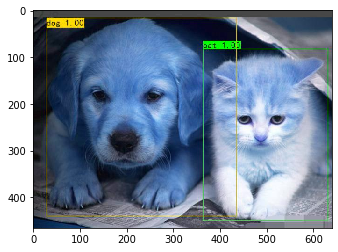

In [5]:
#使用OpenCV开源库读取图片数据
import cv2

from  matplotlib import pyplot as plt
%matplotlib inline


# 读取一张照片,把图片转换为2维的numpy数组
img = cv2.imread('./img_out/cat-dog.jpg')

#使用plt显示图像
plt.imshow(img)